In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
import scipy.signal as signal

In [2]:
# float iir
class FloatIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2):
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.a1 = a1
        self.a2 = a2
        # 初始化存储过去的值, y1 y2为高bit的值
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
    
    def process(self, x):
        # 计算当前输出
        y = (self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - 
             self.a1 * self.y1 - self.a2 * self.y2)

        # 更新历史值
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return y

In [ ]:

# 64 bit
class QuantizedIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2, iir_coeff_bit, output_dec_bits=1, feedback_half_lsb=False):
        # 系数量化
        coeff_quant_factor = np.float64(1 / (2 ** iir_coeff_bit))
        self.b0 = np.round(np.float64(b0) / coeff_quant_factor) * coeff_quant_factor
        self.b1 = np.round(np.float64(b1) / coeff_quant_factor) * coeff_quant_factor
        self.b2 = np.round(np.float64(b2) / coeff_quant_factor) * coeff_quant_factor
        self.a1 = np.round(np.float64(a1) / coeff_quant_factor) * coeff_quant_factor
        self.a2 = np.round(np.float64(a2) / coeff_quant_factor) * coeff_quant_factor
        self.feedback_half_lsb = feedback_half_lsb

        # 初始化历史变量，使用double精度
        self.x1 = np.float64(0)
        self.x2 = np.float64(0)
        self.y1 = np.float64(0)
        self.y2 = np.float64(0)

        # 存储量化因子
        self.coeff_quant_factor = coeff_quant_factor
        self.output_dec_bits = output_dec_bits
        self.output_quant_factor = np.float64(0.5 ** output_dec_bits)

    def process(self, x):
        x = np.float64(x)

        # 反馈部分计算
        y1_q = self.y1 / self.output_quant_factor
        y2_q = self.y2 / self.output_quant_factor
        a1_q = self.a1 / self.coeff_quant_factor
        a2_q = self.a2 / self.coeff_quant_factor

        if self.feedback_half_lsb:
            feed_back_requant = np.floor(
                (a1_q * y1_q + a2_q * y2_q + (a1_q + a2_q) / 2) * self.output_quant_factor
            ) * self.coeff_quant_factor
        else:
            feed_back_requant = np.floor(
                (a1_q * y1_q + a2_q * y2_q) * self.output_quant_factor
            ) * self.coeff_quant_factor

        y = self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - feed_back_requant
        y = np.floor(y / self.output_quant_factor) * self.output_quant_factor

        # 更新历史值
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y

        return np.floor(y)

In [4]:
def analyze_filter_frequency_response(
    float_filter,
    quant_filter,
    N=65536,
    impulse_scale=16384,
    start_ratio=0,
    end_ratio=1,
    title="Frequency Response: Float vs Quantized IIR Filter"
):
    """
    比较浮点 IIR 滤波器和量化 IIR 滤波器的频率响应。
    
    参数:
        float_filter: 浮点 IIR 滤波器对象（需有 process(x) 方法）
        quant_filter: 量化 IIR 滤波器对象（需有 process(x) 方法）
        N: FFT 点数
        impulse_scale: 脉冲幅值
        title: 绘图标题
    """

    # 生成单位脉冲
    impulse = np.zeros(N)
    impulse[0] = 1.0 * impulse_scale

    # 响应
    float_resp = np.zeros(N)
    quant_resp = np.zeros(N)
    quant_err_resp = np.zeros(N)

    for n in range(N):
        float_resp[n] = float_filter.process(impulse[n])
        quant_resp[n] = quant_filter.process(impulse[n])
        quant_err_resp[n] = float_resp[n] - quant_resp[n]

    # FFT
    H_float = np.fft.fft(float_resp)[:N//2]
    H_quant = np.fft.fft(quant_resp)[:N//2]
    H_quant_err = np.fft.fft(quant_err_resp)[:N//2]

    f = np.linspace(0, 0.5, N//2)

    # 屏蔽 DC
    H_float[0] = 0
    H_quant[0] = 0
    H_quant_err[0] = 0

    # dB 幅度响应 (相对浮点滤波器)
    mag_float_db = 20 * np.log10(np.abs(H_float) / np.max(np.abs(H_float)) + 1e-10)
    mag_quant_db = 20 * np.log10(np.abs(H_quant) / np.max(np.abs(H_float)) + 1e-10)
    mag_quant_err_db = 20 * np.log10(np.abs(H_quant_err) / np.max(np.abs(H_float)) + 1e-10)

    # 绘图
    length = len(f)
    start_index = int(start_ratio * length)
    end_index = int(end_ratio * length)

    plt.figure(figsize=(10, 5))
    plt.plot(f[start_index:end_index], mag_float_db[start_index:end_index], label='Float IIR', linewidth=2)
    plt.plot(f[start_index:end_index], mag_quant_db[start_index:end_index], label='Quantized IIR', linewidth=2, linestyle='--')
    plt.plot(f[start_index:end_index], mag_quant_err_db[start_index:end_index], label='Quantization Error', linewidth=2, linestyle=':')
    plt.title(title)
    plt.xlabel("Normalized Frequency (×π rad/sample)")
    plt.ylabel("Magnitude (dB)")
    plt.ylim([-100, 30])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

[ 0.99999111 -1.99998223  0.99999111] [ 1.         -1.99998223  0.99998223]


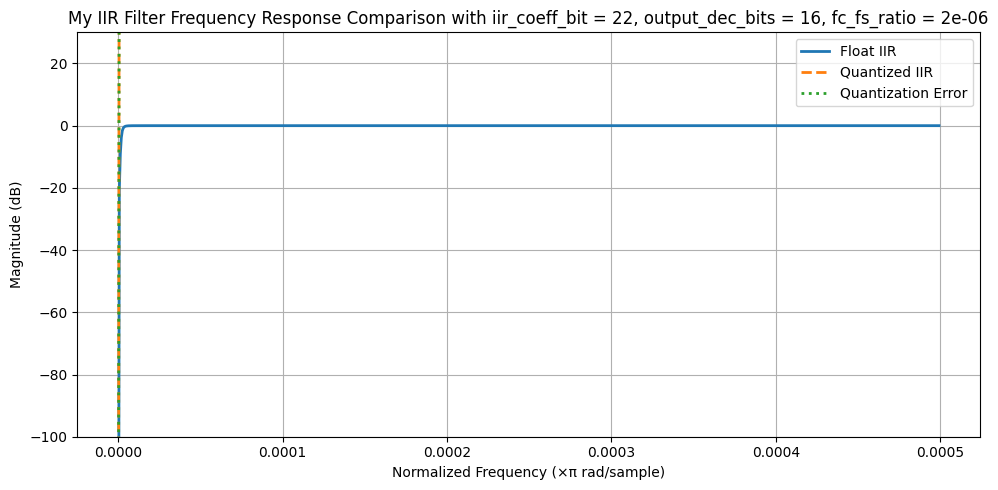

[ 0.99998223 -1.99996446  0.99998223] [ 1.         -1.99996446  0.99996446]


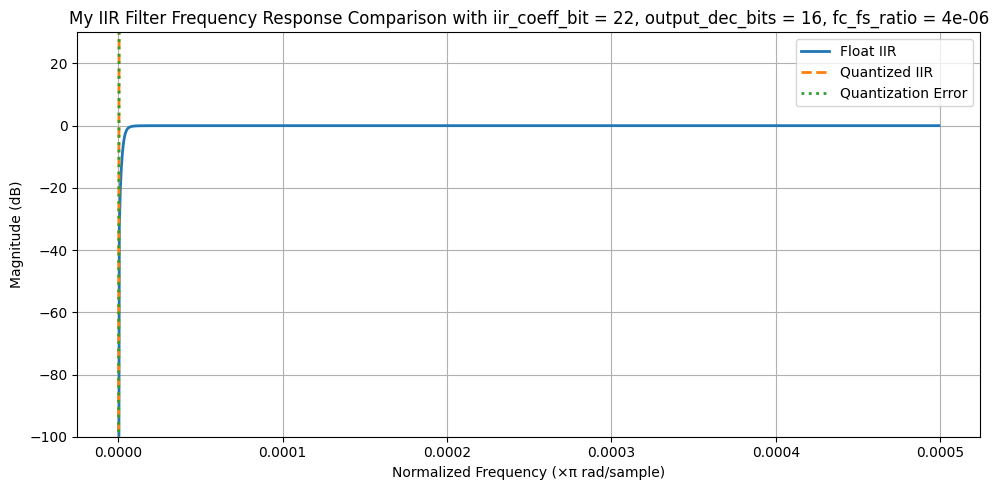

[ 0.99996446 -1.99992892  0.99996446] [ 1.         -1.99992891  0.99992892]


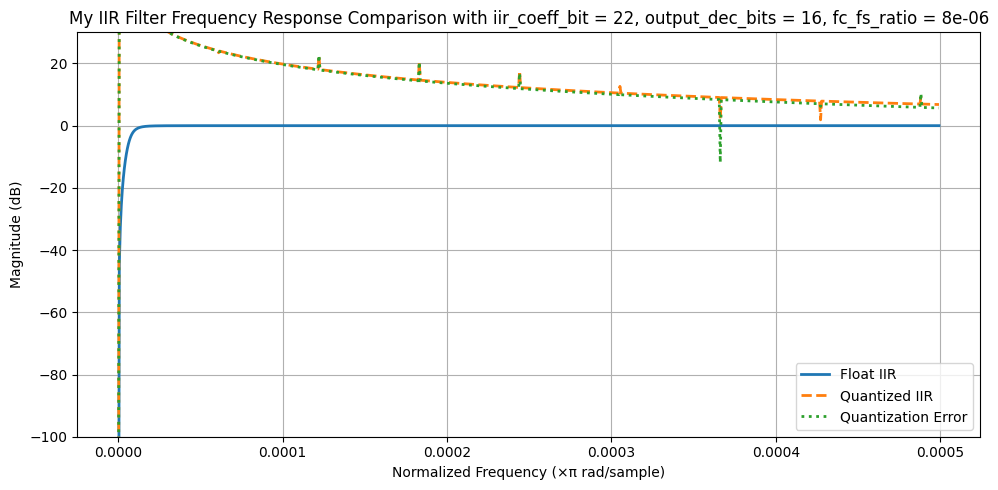

[ 0.99992892 -1.99985783  0.99992892] [ 1.         -1.99985783  0.99985784]


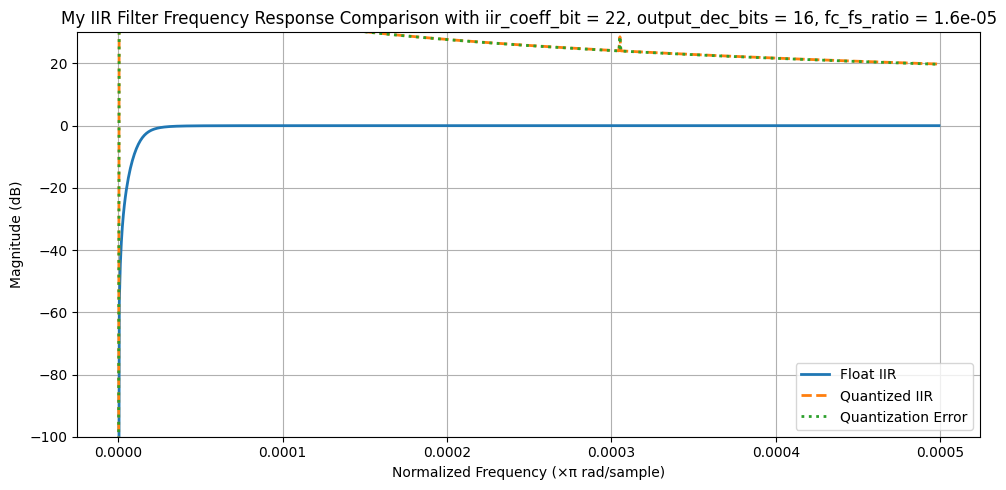

[ 0.99985784 -1.99971568  0.99985784] [ 1.         -1.99971566  0.9997157 ]


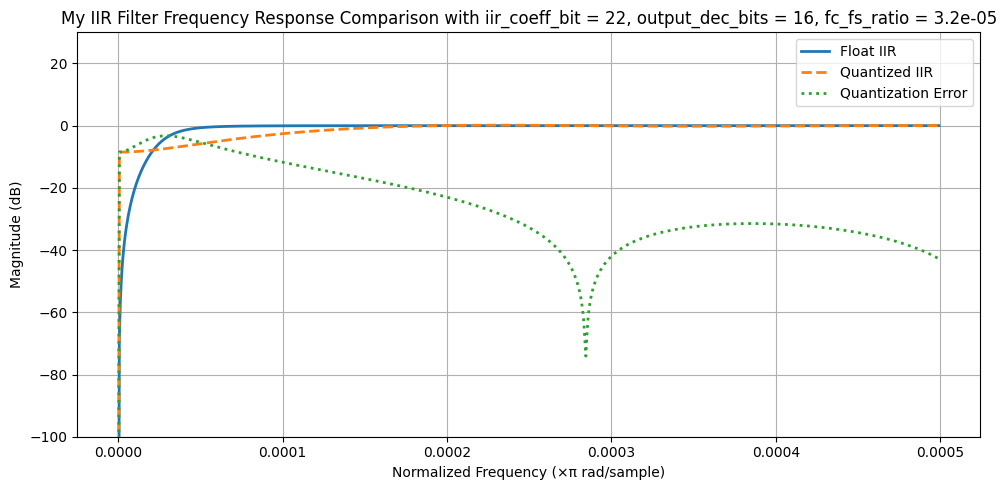

[ 0.9997157  -1.99943139  0.9997157 ] [ 1.         -1.99943131  0.99943147]


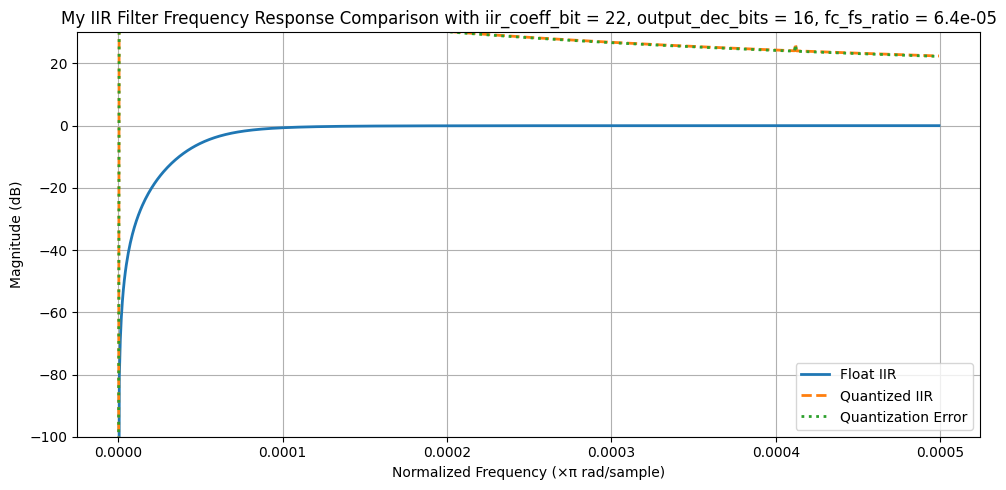

In [5]:

fc_fs_ratio_list = [2e-6, 4e-6, 8e-6, 16e-6, 32e-6, 64e-6]
iir_coeff_bit_list = [22] # [22, 24, 26] #[8, 10, 12, 15, 16]
output_dec_bits_list = [16] # [11, 14, 16] # [11]
start_ratio = 0 
end_ratio = 0.001
for fc_fs_ratio in fc_fs_ratio_list:
    for iir_coeff_bit in iir_coeff_bit_list:
        for output_dec_bits in output_dec_bits_list:
            # 初始化滤波器（替换成你的实际系数）
            b, a = butter(2, 2*fc_fs_ratio, btype='high')
            print(b, a)
            float_filter = FloatIIRFilter(b[0], b[1], b[2], a[1], a[2])
            quant_filter  = QuantizedIIRFilter(
                b0=b[0], b1=b[1], b2=b[2],
                a1=a[1], a2=a[2],
                iir_coeff_bit=iir_coeff_bit,          # 例如 8-bit 系数量化
                output_dec_bits=output_dec_bits,        # 输出小数位
                feedback_half_lsb=False   # 控制反馈是否加offset
            )

            analyze_filter_frequency_response(
                float_filter,
                quant_filter,
                N=1638400,
                impulse_scale=16384,
                start_ratio=start_ratio,
                end_ratio=end_ratio,
                title=f"My IIR Filter Frequency Response Comparison with iir_coeff_bit = {iir_coeff_bit}, output_dec_bits = {output_dec_bits}, fc_fs_ratio = {fc_fs_ratio}"
    )